## Введение 

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

# 1. Первичное исследование
## 1.1 Обзор данных + предобработка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
!pip install phik -q
import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, make_scorer
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")

In [2]:
phone = pd.read_csv('C:/Users/user/Downloads/data123.csv')
personal = pd.read_csv('C:/Users/user/Downloads/personal_new.csv')
contract = pd.read_csv('C:/Users/user/Downloads/contract_new.csv')
internet = pd.read_csv('C:/Users/user/Downloads/internet_new.csv')

In [3]:
phone.info()
personal.info()
contract.info()
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID       

In [4]:
print(phone['customerID'].nunique())
print(personal['customerID'].nunique())
print(contract['customerID'].nunique())
print(internet['customerID'].nunique())

6361
7043
7043
5517


В датафреймах разное количество строк, id клиентов не повторяются. Объединим датасет.

In [5]:
data = contract.merge(personal, on='customerID',how='outer').merge(phone, on='customerID',how='outer').merge(
    internet,on='customerID',how='outer')

In [6]:
data.duplicated().sum()

0

In [7]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Yes,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,NaN,DSL,Yes,No,No,No,No,No
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,No,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,No,Yes,No,DSL,Yes,Yes,No,No,No,No


Дубликатов нет. 
Для дальнейшего анализа необходимо заполнить пропуски и изменить типы данных.

Заполним пропущенные значения.


In [8]:
data['InternetService'] = data['InternetService'].fillna('NotConnected')
data['MultipleLines'] = data['MultipleLines'].fillna('NotConnected')
data = data.fillna('No')

Формируем новый столбец - наш целевой признак(ушел клиент или нет)

In [9]:
data['Left'] = data['EndDate'].apply(lambda x: False if x == 'No' else True)

In [10]:
data[['Left','EndDate']].head(15)

,Left,EndDate
0,False,No
1,False,No
2,False,No
3,False,No
4,False,No
5,False,No
6,False,No
7,False,No
8,False,No
9,True,2017-05-01


Преобразовываем типы данных

In [11]:
data['Partner'] = data['Partner'].map({'Yes': True, 'No': False})
data['Dependents'] = data['Dependents'].map({'Yes': True, 'No': False})
data['PaperlessBilling'] = data['PaperlessBilling'].map({'Yes': True, 'No': False})
data['SeniorCitizen'] = data['SeniorCitizen'].map({1 : True, 0 : False})

Добавляем столбец DateDiff с информацией сколько времени человек является клиентом услуг оператора.


In [12]:
data['DateBeginDate'] = pd.to_datetime(data['BeginDate'],format='%Y-%m-%d')
data['DateEndDate'] = pd.to_datetime(data['EndDate'],format='%Y-%m-%d',errors='coerce')

In [13]:
data['DateEndDate'] = data['DateEndDate'].fillna('2020-02-01')
data['DateEndDate'] = pd.to_datetime(data['DateEndDate'],format='%Y-%m-%d')

In [14]:
data['DateDiff'] = data['DateEndDate'] - data['DateBeginDate']

In [15]:
data['DateDiff'] = data['DateDiff'].astype('timedelta64[D]').astype(int)

Изменение типа данных колонки TotalCharges приводит к ошибке - could not convert string to float: ' '

Посмотрим на пустые значения в столбце

In [16]:
data.query('TotalCharges == " "')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Left,DateBeginDate,DateEndDate,DateDiff
488,4472-LVYGI,2020-02-01,No,Two year,True,Bank transfer (automatic),52.55,,Female,False,...,Yes,No,Yes,Yes,Yes,No,False,2020-02-01,2020-02-01,0
753,3115-CZMZD,2020-02-01,No,Two year,False,Mailed check,20.25,,Male,False,...,No,No,No,No,No,No,False,2020-02-01,2020-02-01,0
936,5709-LVOEQ,2020-02-01,No,Two year,False,Mailed check,80.85,,Female,False,...,Yes,Yes,Yes,No,Yes,Yes,False,2020-02-01,2020-02-01,0
1082,4367-NUYAO,2020-02-01,No,Two year,False,Mailed check,25.75,,Male,False,...,No,No,No,No,No,No,False,2020-02-01,2020-02-01,0
1340,1371-DWPAZ,2020-02-01,No,Two year,False,Credit card (automatic),56.05,,Female,False,...,Yes,Yes,Yes,Yes,Yes,No,False,2020-02-01,2020-02-01,0
3331,7644-OMVMY,2020-02-01,No,Two year,False,Mailed check,19.85,,Male,False,...,No,No,No,No,No,No,False,2020-02-01,2020-02-01,0
3826,3213-VVOLG,2020-02-01,No,Two year,False,Mailed check,25.35,,Male,False,...,No,No,No,No,No,No,False,2020-02-01,2020-02-01,0
4380,2520-SGTTA,2020-02-01,No,Two year,False,Mailed check,20.00,,Female,False,...,No,No,No,No,No,No,False,2020-02-01,2020-02-01,0
5218,2923-ARZLG,2020-02-01,No,One year,True,Mailed check,19.70,,Male,False,...,No,No,No,No,No,No,False,2020-02-01,2020-02-01,0
6670,4075-WKNIU,2020-02-01,No,Two year,False,Mailed check,73.35,,Female,False,...,No,Yes,Yes,Yes,Yes,No,False,2020-02-01,2020-02-01,0


Пустые значения в столбце TotalCharges у февральских клиентов. Заполним TotalCharges значением MonthlyCharges для данных клиентов.

In [17]:
data.loc[data['TotalCharges'] == ' ','TotalCharges'] = data['MonthlyCharges']
data['TotalCharges'] = data['TotalCharges'].astype(float)

In [18]:
data.describe()
#data.info()

,MonthlyCharges,TotalCharges,DateDiff
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.377573,898.555729
std,30.090047,2112.678861,683.130510
min,18.250000,19.050000,0.000000
25%,35.500000,436.750000,276.000000
50%,70.350000,1343.350000,761.000000
75%,89.850000,3236.690000,1461.000000
max,118.750000,9221.380000,2314.000000


Посмотрим на признаки более подробно.


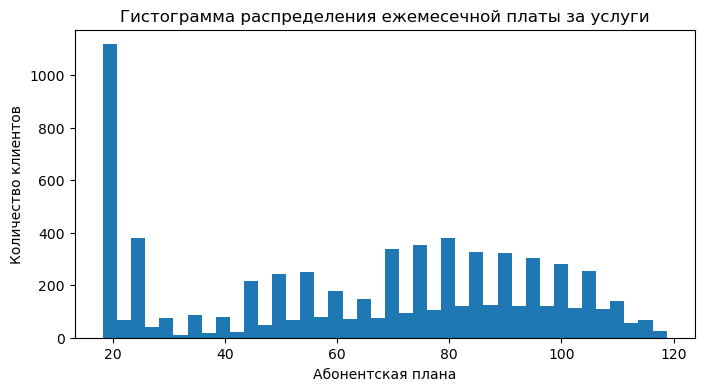

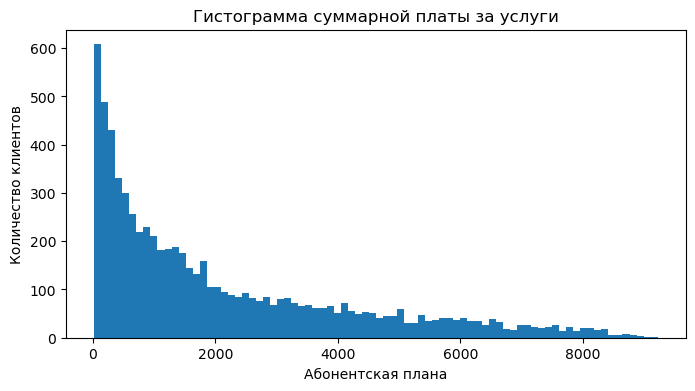

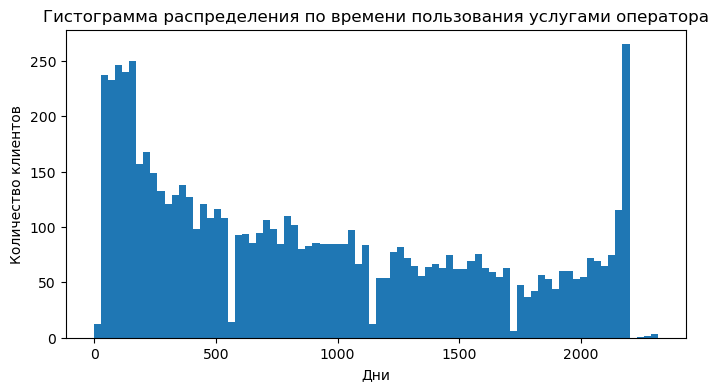

In [19]:
plt.figure(figsize=[8,4])
plt.hist(data['MonthlyCharges'], bins=40,label='MonthlyCharges')
plt.xlabel("Абонентская плана")
plt.ylabel("Количество клиентов")
plt.title("Гистограмма распределения ежемесечной платы за услуги")
plt.show()

plt.figure(figsize=[8,4])
plt.hist(data['TotalCharges'], bins=80,label='TotalCharges')
plt.xlabel("Абонентская плана")
plt.ylabel("Количество клиентов")
plt.title("Гистограмма суммарной платы за услуги")
plt.show()

plt.figure(figsize=[8,4])
plt.hist(data['DateDiff'], bins=80,label='DateDiff')
plt.xlabel("Дни")
plt.ylabel("Количество клиентов")
plt.title("Гистограмма распределения по времени пользования услугами оператора")
plt.show()

Распределение переменной TotalCharges похоже на усеченное нормальное, MonthlyCharges и DateDiff распределенны бимодально.

Такие графики мало о чем говорят, поэтому лучше смотреть на распределение по нашему целевому признаку.

**Дальнейший план работы**
- Построить портрет уходящего клиента
- Посмотреть на корреляцию признаков с таргетом
- Выбрать подходящие признаки для обучения модели
- **Следущий блок**:
- Подготовка данных к обучению (кодирование, маштабирование...)
- Исследование моделей (подбор гиперпараметров и выбор лучшей модели)
- Тестирование и анализ важности признаков (если понадобится добавить/удалить признаки)
- **Блок с оценкой прибольности**
- **Подготовка отчета**

## 1.2 Анализ признаков, портрет уходящего клиента.

Ещё раз посмотрим на плотность распределения количественных признаков у двух категорий клиентов. Из-за дисбаланса классов используем kdeplot.

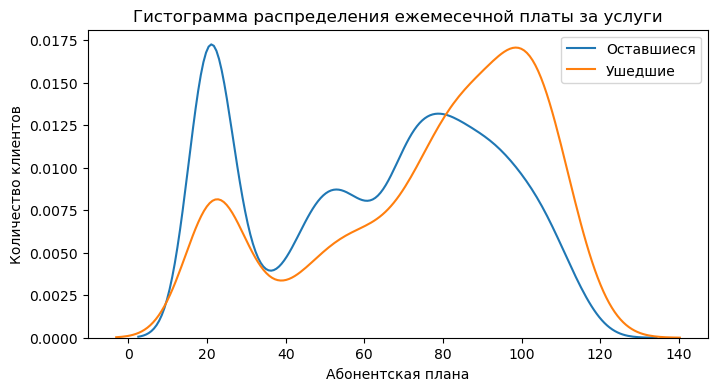

In [20]:
plt.figure(figsize=[8,4])
sns.kdeplot(data.query('Left == 0')['MonthlyCharges'], label='Оставшиеся')
sns.kdeplot(data.query('Left == 1')['MonthlyCharges'], label='Ушедшие')
plt.xlabel("Абонентская плана")
plt.ylabel("Количество клиентов")
plt.title("Гистограмма распределения ежемесечной платы за услуги")
plt.legend()
plt.show()

Клиенты с абонентской платой выше 80 уходят чаще. Соотношение ушедшних к оставшимся клиентов с низкой абонентской платой довольно высокое.

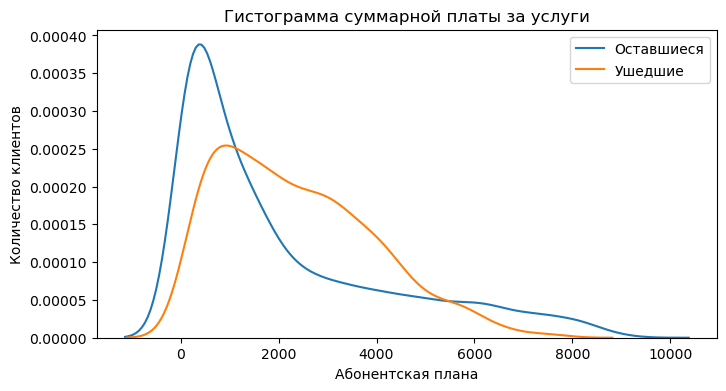

In [21]:
plt.figure(figsize=[8,4])
sns.kdeplot(data.query('Left == 0')['TotalCharges'], label='Оставшиеся')
sns.kdeplot(data.query('Left == 1')['TotalCharges'], label='Ушедшие')
plt.xlabel("Абонентская плана")
plt.ylabel("Количество клиентов")
plt.title("Гистограмма суммарной платы за услуги")
plt.legend()
plt.show()

Похожая ситуация и с totalCharges. Можно сформулировать гипотезу о лояльности старых клиентов (а какие факторы на это влияют мы выясним позже)


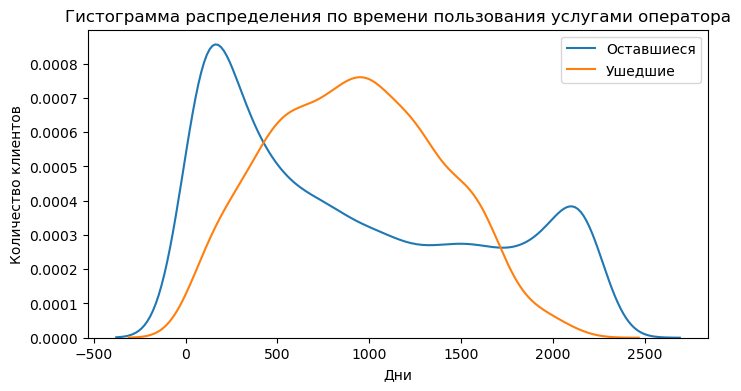

In [22]:
plt.figure(figsize=[8,4])
sns.kdeplot(data.query('Left == 0')['DateDiff'], label='Оставшиеся')
sns.kdeplot(data.query('Left == 1')['DateDiff'], label='Ушедшие')
plt.xlabel("Дни")
plt.ylabel("Количество клиентов")
plt.title("Гистограмма распределения по времени пользования услугами оператора")
plt.legend()
plt.show()

Распределение ушедших клиентов больше похоже на нормальное. У лояльных клиентов распределение бимодальное. Чаще всего клиенты уходят по истечении 3х лет/

Категориальных переменных много, выберим наиболее важные, исходя из таблицы корреляции.

In [23]:
cor_matr = data.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'DateDiff'])
cor_matr['Left'].sort_values(ascending=False)

customerID          1.000000
EndDate             1.000000
DateEndDate         1.000000
Left                1.000000
DateBeginDate       0.450254
BeginDate           0.450254
DateDiff            0.374569
TotalCharges        0.304287
OnlineBackup        0.229482
Partner             0.226688
MonthlyCharges      0.226280
StreamingMovies     0.222232
DeviceProtection    0.218380
PaymentMethod       0.214832
StreamingTV         0.200198
OnlineSecurity      0.132594
MultipleLines       0.105101
TechSupport         0.103652
Type                0.094015
SeniorCitizen       0.086159
PaperlessBilling    0.083398
InternetService     0.056621
Dependents          0.046871
gender              0.008581
Name: Left, dtype: float64

Посмотрим на распределение следующих признаков: PaymentMethod Partner MultipleLines OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies

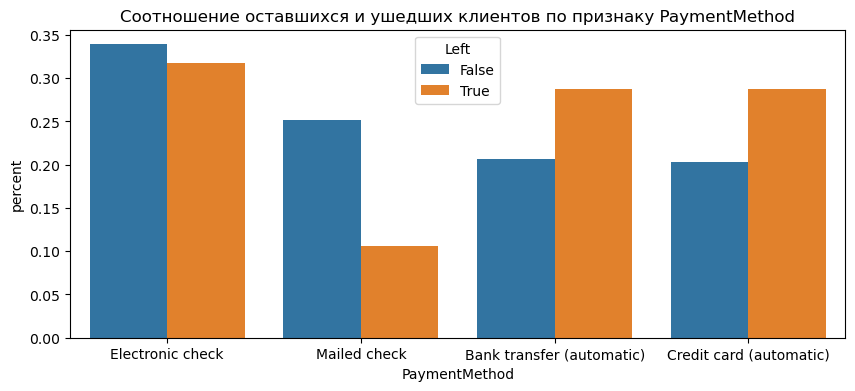

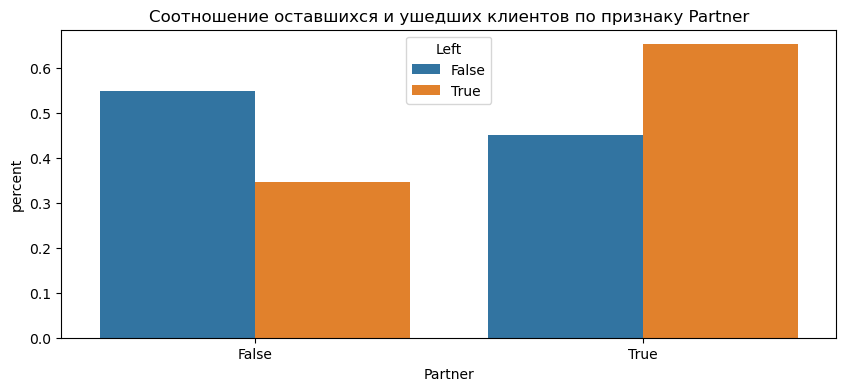

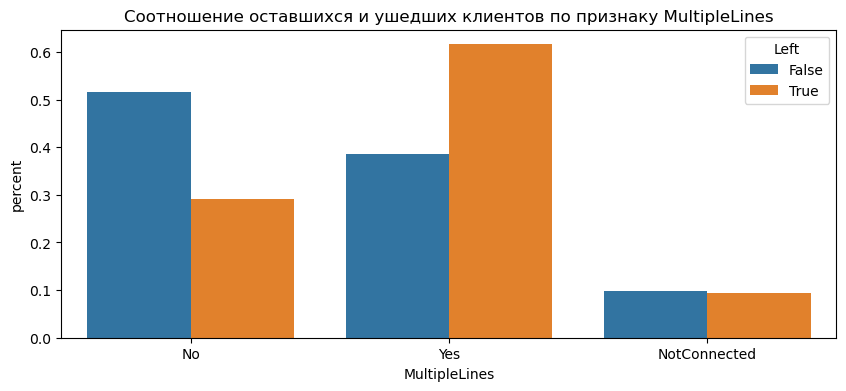

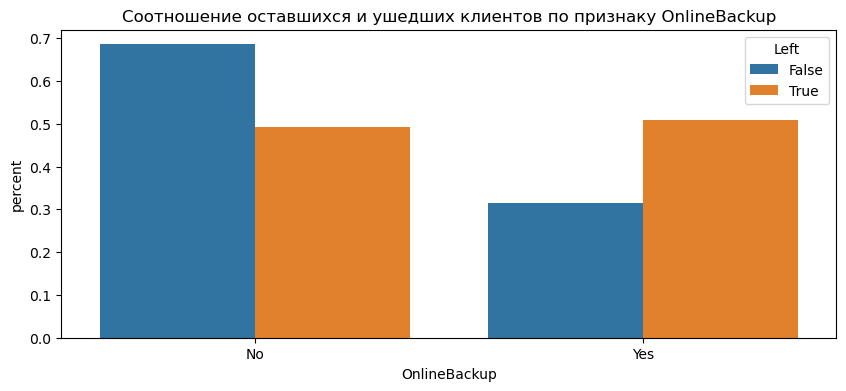

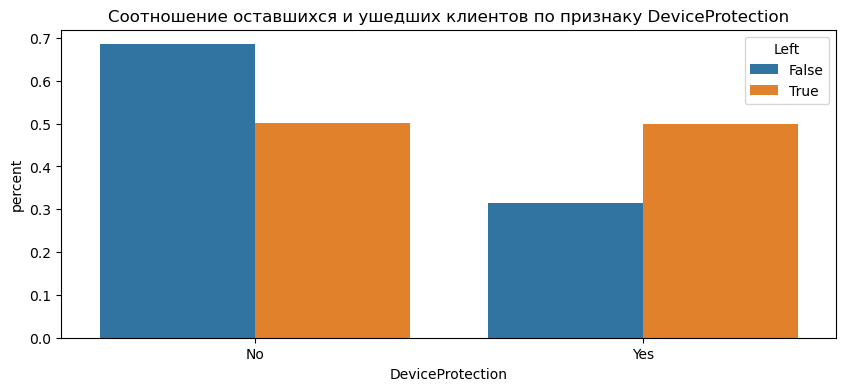

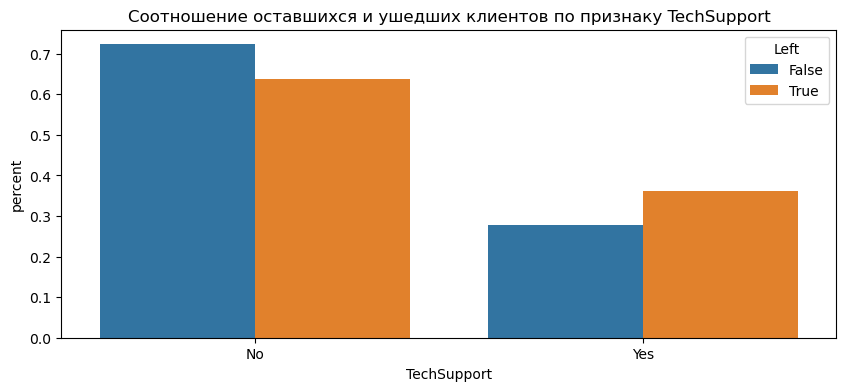

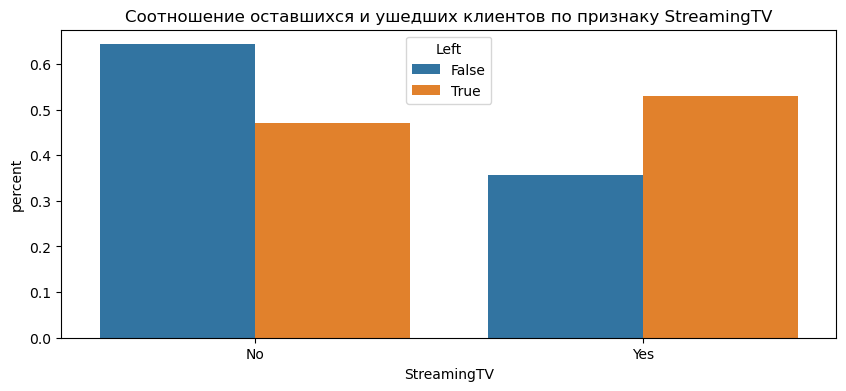

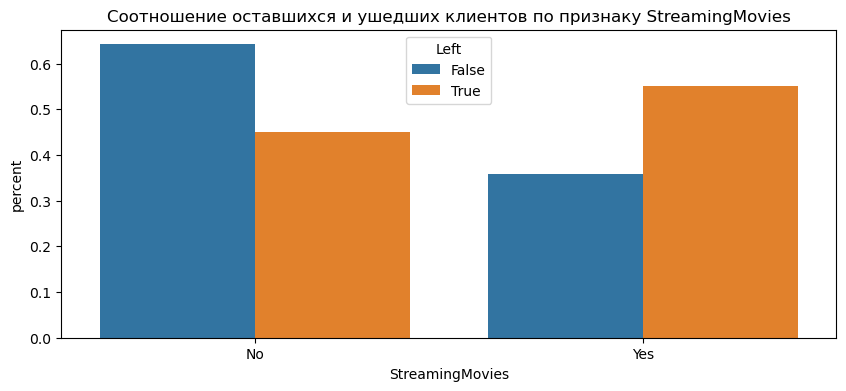

In [24]:
columns = ['PaymentMethod','Partner','MultipleLines','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
           'StreamingMovies']
for i in columns:
    plt.figure(figsize=[10,4])
    percentage = data[i].groupby(data['Left']).value_counts(normalize=True).rename('percent').reset_index()
    sns.barplot(x=i, y='percent', hue='Left', data=percentage)
    plt.title('Соотношение оставшихся и ушедших клиентов по признаку ' + i)
    plt.show()

- Реже всего уходят клиенты с оплатой по почте (mailed check). Среди клиентов с автоматической оплатой доля ушедших чуть больше.
- Одинокие клиенты (признак partner) уходят реже.
- Клиенты пользующиеся услугой Подключение нескольких линий (MultipleLines) уходят чаще.
- По доп услугам интернета (датафрейм internet) ситуация аналогичная: в процентном соотношении, клиенты с подключенными доп услугами, уходят чаще.

Выводы скорее контринтуитивны. 

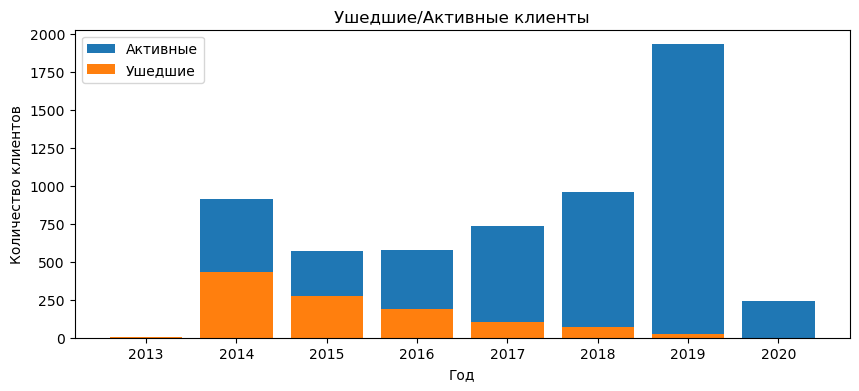

In [25]:
yearly_data = data.groupby(data['DateBeginDate'].dt.year)['Left'].sum()
yearly_data2 = data.query('Left == 0').groupby(data['DateBeginDate'].dt.year)['Left'].count()
plt.figure(figsize=[10,4])
plt.bar(yearly_data2.index, yearly_data2.values, label ='Активные')
plt.bar(yearly_data.index, yearly_data.values,label = 'Ушедшие')
plt.xlabel('Год')
plt.ylabel('Количество клиентов')
plt.title('Ушедшие/Активные клиенты')
plt.legend()
plt.show() 

Количество новых клиентов растет с 2015 года, а в основном уходят старые клиенты.

## 1.3 Смотрим корреляцию и выбираем признаки для будущей модели

Сразу удалим ненужные признаки (BeginDate, EndDate и все остальные "даты", кроме DateDiff) и ещё раз посмотрим на таблицу корреляции.

In [26]:
dataX = data.drop(['customerID','DateEndDate','DateBeginDate','BeginDate','EndDate'],axis=1)

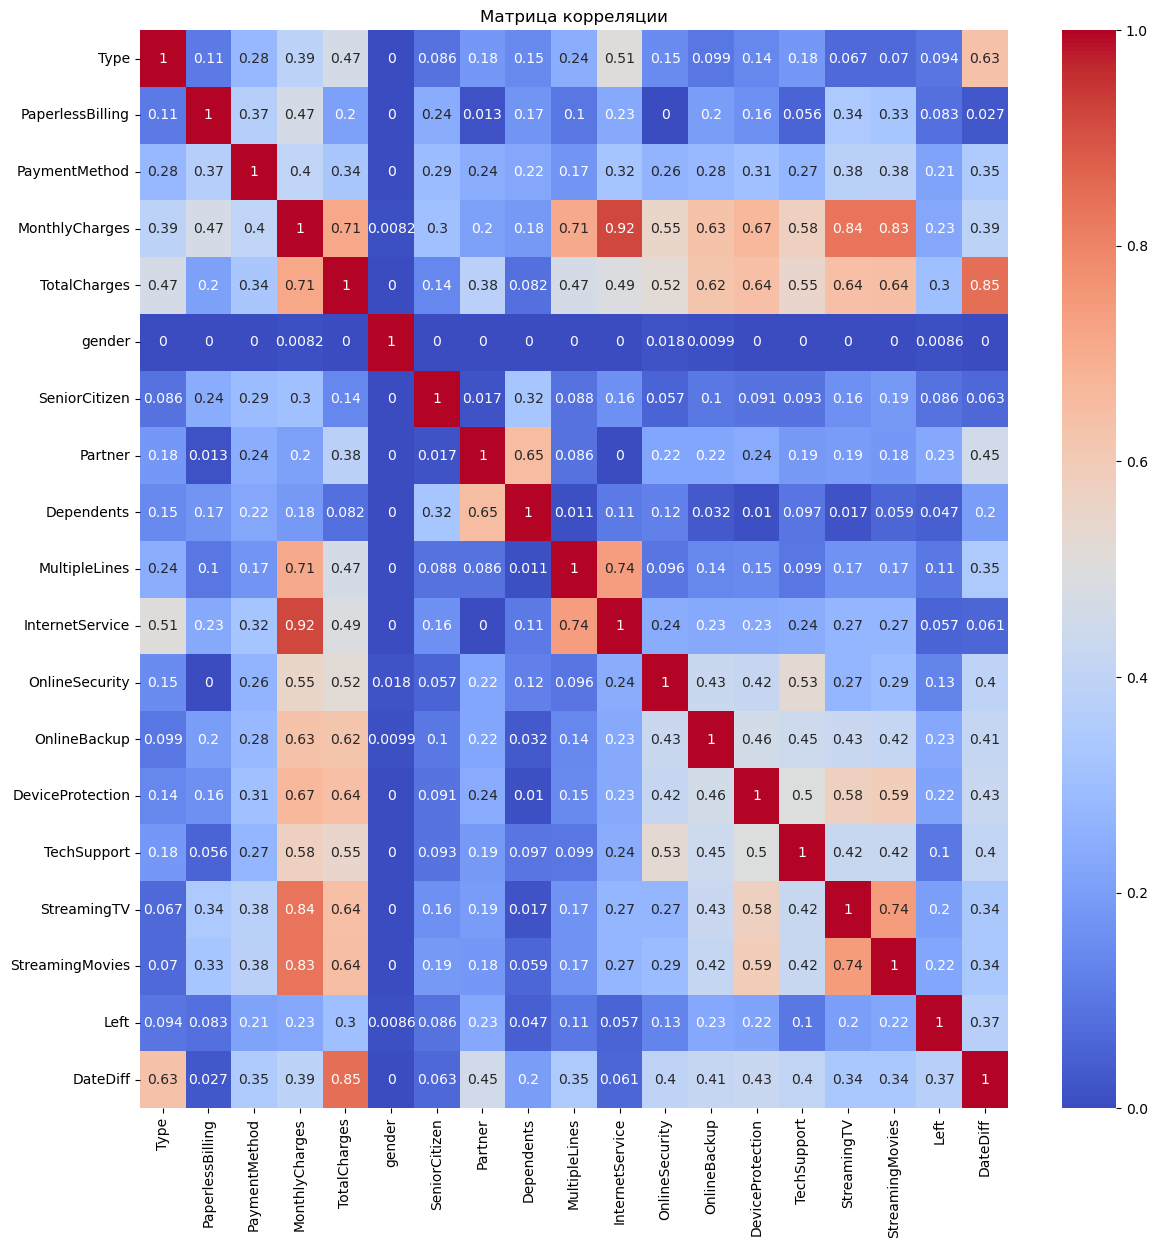

In [27]:
#dataX.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'DateDiff'])
plt.figure(figsize=[14,14])
sns.heatmap(dataX.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'DateDiff']), annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

Для обучения модели мы:
* Отбираем переменные, которые высоко коррелируют с целевым признаком
* Исключаем переменные, которые сильно коррелируют между собой (тут это все признаки из датафрейма internet)

LogisticRegression из sklearn согласно дефолтным настройкам использует L2 регуляризацию, которая способна бороться с проблемой мультиколлинеарности, поэтому для этой модели набор признаков в целом можно не ограничивать (как и для деревьев). Но с другой стороны оставление скоррелированных признаков может помешать оценке важности (при некторых подходах) и излишне нагружать модель

gender Dependents InternetService имеют слабую корреляцию с целевым признаком.

StreamingTV  - StreamingMovies; TotalCharges - DateDiff; InternetService - MonthlyCharges сильно коррелируют между собой

In [28]:
data_left = dataX.drop(['gender','Dependents','InternetService','TotalCharges',
                       'StreamingMovies'],axis=1)


Если результат не оправдает ожиданий, можем продолжить исключать признаки или добавлять новые, отталкиваясь от результатов модели(веса признаков)

## 1.4 Кодирование признаков, разбиение на выборки 

Разбиение 3/1. Кодирование в пайплайнах.

In [29]:
features = data_left.drop(['Left'], axis=1)
target = data_left['Left']

features_train, features_test, target_train, target_test = train_test_split(features,target,test_size=0.25,random_state=80523)

In [30]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(5282, 13)
(1761, 13)
(5282,)
(1761,)


In [31]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   bool   
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   SeniorCitizen     7043 non-null   bool   
 5   Partner           7043 non-null   bool   
 6   MultipleLines     7043 non-null   object 
 7   OnlineSecurity    7043 non-null   object 
 8   OnlineBackup      7043 non-null   object 
 9   DeviceProtection  7043 non-null   object 
 10  TechSupport       7043 non-null   object 
 11  StreamingTV       7043 non-null   object 
 12  DateDiff          7043 non-null   int32  
dtypes: bool(3), float64(1), int32(1), object(8)
memory usage: 856.4+ KB


Объединяем категории признаков для дальнейшего преобразования с помощью ColumnTransformer.

In [32]:
cat_features = ['Type','PaperlessBilling', 'MultipleLines','SeniorCitizen','OnlineBackup','PaymentMethod','Partner',
               'StreamingTV','TechSupport','DeviceProtection','OnlineSecurity']
num_features = ['MonthlyCharges','DateDiff']


In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore',drop='first'), cat_features),
        ('num', StandardScaler(), num_features)])

## 1.5 Исследование моделей

__RandomForestClassifier__

{'model__max_depth': 6, 'model__n_estimators': 170}
roc_auc : 0.8276747462561476
accuracy : 0.8534648160889882


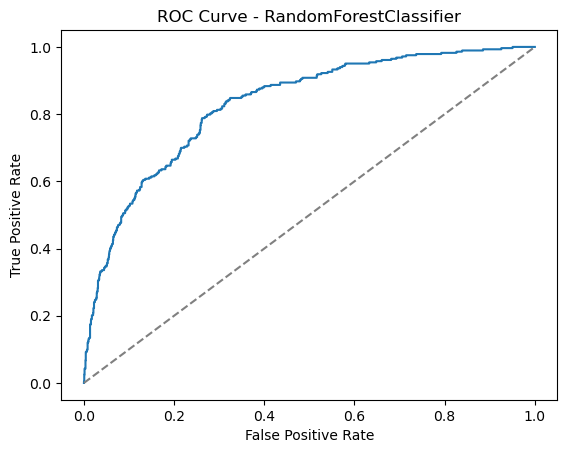

In [34]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
pipeline = Pipeline(steps=[('preprocessing', preprocessor),
                           ('model', RandomForestClassifier(random_state=80523))])
parametrs = { 
    'model__n_estimators': range (10, 200, 20),
    'model__max_depth': range (2, 8, 2)
}

grid = GridSearchCV(pipeline, parametrs, cv=5,scoring=scoring, refit='AUC')
grid.fit(features_train, target_train)
print(grid.best_params_)
print('roc_auc :', grid.best_score_)
print('accuracy :', grid.cv_results_['mean_test_Accuracy'][grid.best_index_])
rf_roc = grid.best_score_
rf_acc = grid.cv_results_['mean_test_Accuracy'][grid.best_index_]

predictions_proba = grid.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, predictions_proba[:, 1])
fpr, tpr, thresholds = roc_curve(target_test, predictions_proba[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForestClassifier')
plt.show()

__LGBMClassifier__


In [35]:
pipeline = Pipeline(steps=[('preprocessing', preprocessor),
                           ('classifier', LGBMClassifier(random_state=80523))])
param_grid = {
    'classifier__n_estimators': range(100, 500, 100),
    'classifier__learning_rate': [0.01, 0.1, 0.5],
    'classifier__max_depth': [3, 15, 3]
}

In [36]:
%%time

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scoring,refit='AUC')
grid_search.fit(features_train, target_train)
print(grid_search.best_params_)
print('roc_auc :', grid_search.best_score_)
print('accuracy :', grid_search.cv_results_['mean_test_Accuracy'][grid_search.best_index_])
lgm_roc = grid_search.best_score_
lgm_acc = grid_search.cv_results_['mean_test_Accuracy'][grid_search.best_index_]

{'classifier__learning_rate': 0.5, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
roc_auc : 0.9029937136048078
accuracy : 0.9096967188440697
CPU times: total: 1.03 s
Wall time: 12.8 s


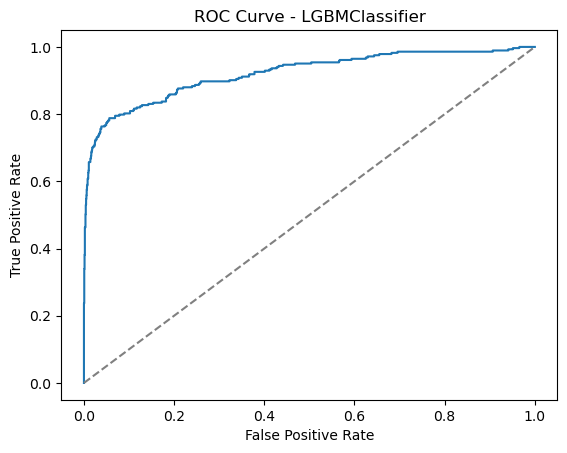

In [37]:
predictions_proba = grid_search.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, predictions_proba[:, 1])
fpr, tpr, thresholds = roc_curve(target_test, predictions_proba[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LGBMClassifier')
plt.show()

__XGBClassifier__

In [38]:
pipeline = Pipeline(steps=[('preprocessing', preprocessor),
                           ('classifier', XGBClassifier(random_state=80523))])
param_grid = {
    'classifier__n_estimators': range(200, 400, 100),
    'classifier__learning_rate': [0.01, 0.1, 0.5],
    'classifier__max_depth': range(3, 9, 3)
}

In [39]:
%%time
grid_search2 = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1,scoring=scoring, refit='AUC')
grid_search2.fit(features_train, target_train)
print('roc_auc :', grid_search2.best_score_)
print('accuracy :', grid_search2.cv_results_['mean_test_Accuracy'][grid_search2.best_index_])
xgm_roc = grid_search2.best_score_
xgm_acc = grid_search2.cv_results_['mean_test_Accuracy'][grid_search2.best_index_]

roc_auc : 0.917841708675555
accuracy : 0.9172690719876151
CPU times: total: 1.66 s
Wall time: 19.5 s


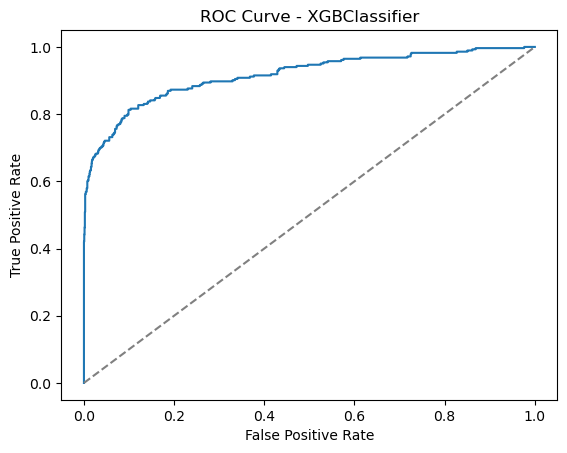

In [40]:
predictions_proba = grid_search2.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, predictions_proba[:, 1])
fpr, tpr, thresholds = roc_curve(target_test, predictions_proba[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBClassifier')
plt.show()

__CatBoostClassifier__

In [41]:
target_train_catBoost = target_train.astype(int)

In [42]:
pipeline = Pipeline(steps=[('preprocessing', preprocessor),
                           ('classifier', CatBoostClassifier(iterations=1000,verbose=False,random_state=80523))
])

param_grid = {
    'classifier__learning_rate': [0.02, 0.1, 0.5],
    'classifier__depth': [3, 5, 7]
}

In [43]:
%%time
grid_search3 = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1,scoring=scoring, refit='AUC')
grid_search3.fit(features_train, target_train_catBoost)
print(grid_search3.best_params_)

{'classifier__depth': 3, 'classifier__learning_rate': 0.1}
CPU times: total: 6.33 s
Wall time: 1min 20s


In [44]:
print('roc_auc :', grid_search3.best_score_)
print('accuracy :', grid_search3.cv_results_['mean_test_Accuracy'][grid_search3.best_index_])
cat_roc = grid_search3.best_score_
cat_acc = grid_search3.cv_results_['mean_test_Accuracy'][grid_search3.best_index_]

roc_auc : 0.9267701352835103
accuracy : 0.9246523895530518


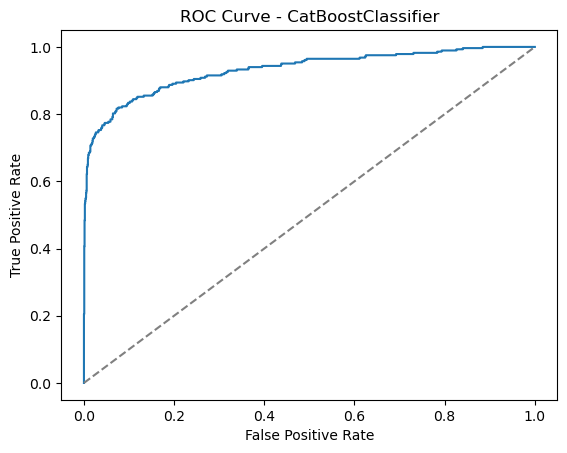

In [45]:
predictions_proba = grid_search3.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, predictions_proba[:, 1])
fpr, tpr, thresholds = roc_curve(target_test, predictions_proba[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoostClassifier')
plt.show()

**Вывод по обучению**

CatBoostClassifier - имеет самое высокое значение accuracy и roc-auc. Дальше с незначительным отрывом идет XGBClassifier, а за ним LGBMClassifier. Дерево решений с задачей не справилось


__Таблица результатов__

In [46]:
results = {'Модель':['RandomForestClassifier', 'CatBoostClassifier', 'XGBClassifier', 'LGBMClassifier'], 
        'Accuracy':[rf_acc, cat_acc, xgm_acc, lgm_acc],
        'AUC-ROC': [rf_roc, cat_roc, xgm_roc, lgm_roc]}

In [47]:
display(pd.DataFrame(results))

,Модель,Accuracy,AUC-ROC
0,RandomForestClassifier,0.853465,0.827675
1,CatBoostClassifier,0.924652,0.926770
2,XGBClassifier,0.917269,0.917842
3,LGBMClassifier,0.909697,0.902994


Балансировка классов необязательна, так как метрика ROC-AUC не чувствительна к дисбалансу, потому что она оценивает способность модели различать между собой положительные и отрицательные примеры независимо от их соотношения в выборке. 

## 2 Тестирование модели. Оценка модели

Наилучшая модель cat boost. Протестируем её и выведем важность признаков.

AUC-ROC: 0.931951304647193
Accuracy: 0.9392390687109596


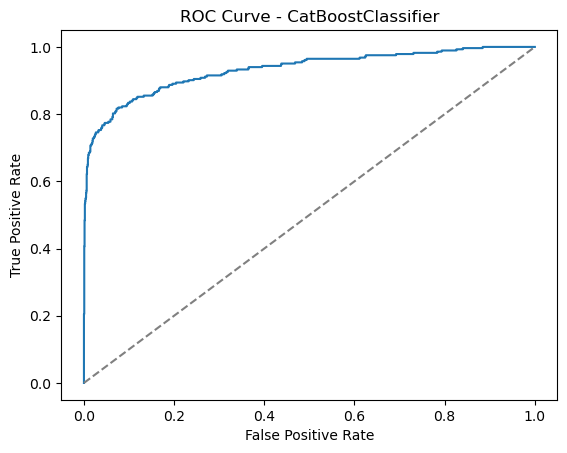

In [48]:
predictions_proba = grid_search3.predict_proba(features_test)
predictions = grid_search3.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
auc_roc = roc_auc_score(target_test, predictions_proba[:, 1])
print('AUC-ROC:', auc_roc)
print('Accuracy:', accuracy)
fpr, tpr, thresholds = roc_curve(target_test, predictions_proba[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoostClassifier')
plt.show()

Если бейзлайновая модель - делает случайный выбор, то значение auc-roc будет 0.5. Наша модель значительно превышает результаты такой модели. 

Важность признаков.

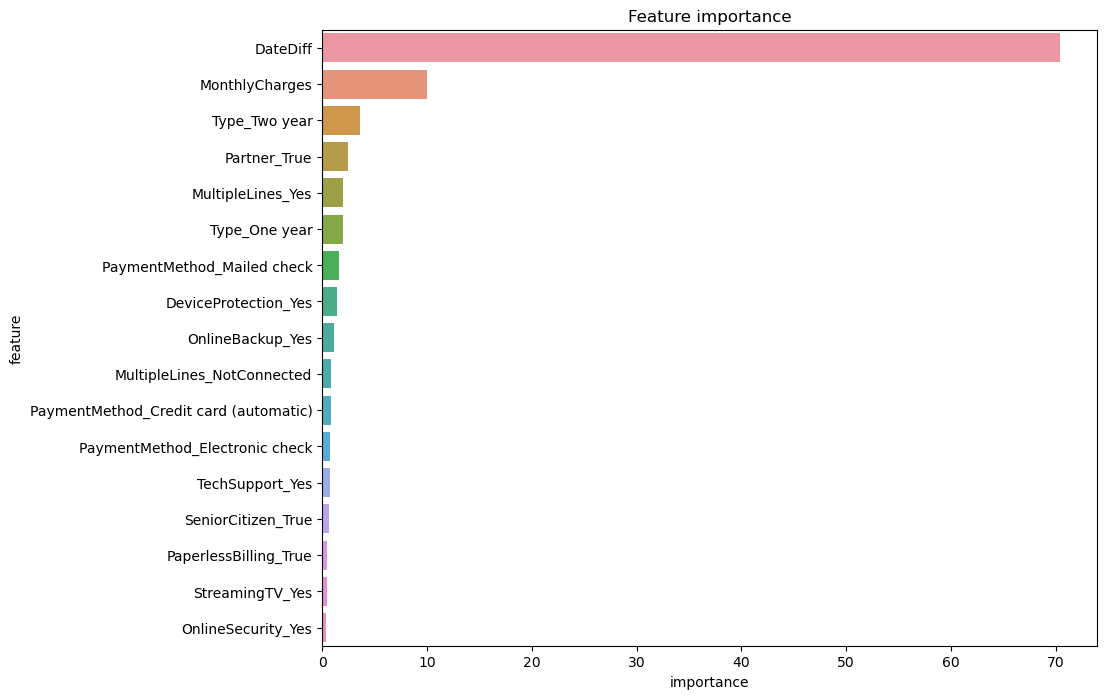

In [49]:
importances = grid_search3.best_estimator_.named_steps['classifier'].feature_importances_
features = grid_search3.best_estimator_.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out(
    cat_features).tolist() + num_features

feat_imp = pd.DataFrame({'feature': features, 'importance': importances})
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feat_imp)
plt.title('Feature importance')
plt.show()

У модели catBoost самый важный признак - DateDiff (время пользования услугами), что было заметно на гистаграммах на предварительной обрабтке данных.
Далее идет: стоимость месячной подписки, тип подписки и наличие партнера.

Интересно, что у модели XGBClassifier более сбалансированные веса у признаков и dateDiff даже не в первой пятерке. Может это связанно с переобучением.

Выводы: наилучшая модель catBoost, LGBm и XGB чуть уступают по качеству метрик. Можно попытаться переобучить модель на ограниченном количестве признаков, если значения roc-auc и accuracy не впечатлят заказчика. Время обучения у всех моделей не большое, так что при запуске в продакшен не должно быть проблем.

Результаты catBoost:

AUC-ROC: 0.931

Accuracy: 0.939

## 3 Оценка прибыльности 

In [50]:
conf_matrix = confusion_matrix(target_test, predictions)
print(conf_matrix)

TP = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
TN = conf_matrix[1][1]

# вычисляем прибыль от TP, FP и FN
profit_TP = TP * features_test['MonthlyCharges'].mean()
loss_FP = FP * features_test['MonthlyCharges'].mean()
loss_FN = FN * features_test['MonthlyCharges'].mean()

total_profit = profit_TP - loss_FP - loss_FN
print(total_profit)

[[1464   14]
 [  93  190]]
88222.29963089155


Я использовал ['MonthlyCharges'].mean(), вместо суммы, определенного клиента..но я тут забил

# Отчет 

__Ключевые шаги__


- Предварительный анализ данных
- Предобработка данных
- Подробный анализ данных
- Выделение признаков
- Преобразование признаков
- Построение моделей, подбор гиперпараметров. Выбор наилучшей модели.
- Тестирование модели

__Для обучения использовались:__
```
Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges','TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents','MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies','Left', 'DateDiff'
```
Вместо признаков EndDate, BeginDate был создан новый признак - DateDIff (сколько времени клиент пользуется услугами).
Признаки для обучения отбирались с помощью матрицы корреляции. Переменные, которые коррелировали между собой были исключены (
gender, Dependents,InternetService. имеют слабую корреляцию с целевым признаком) (StreamingTV - StreamingMovies; TotalCharges - DateDiff; InternetService - MonthlyCharges сильно коррелируют между собой).


Целевой признак 'Left' был выведен из признака EndDate. 1 - означает уход клиента, 0 - остался.

__Описание предобработки__

Пропуски в данных были заполнены значениями "NotConnected" и 'No'. Причина пропусков - не все пользователи одновременно пользуются услугами связи и интернета (или доп. услугами). Далее преобразовали тип данных и избавились от пропусков в столбце TotalCharges (пропуски были у клиентов пришедших в феврале (данные датасета заканчиваются на феврале).

Категориальные признаки были кодированны с помощью OneHotEncoder.
Количественные были маштабированны - StandardScaler`ом.

__Описание проверенных подходов__

В ходе тестирования были исследованы следующее модели: RandomForestClassifier, CatBoostClassifier, XGBClassifier, LGBMClassifier. Результаты на тестовой выборке:

In [51]:
display(pd.DataFrame(results))

,Модель,Accuracy,AUC-ROC
0,RandomForestClassifier,0.853465,0.827675
1,CatBoostClassifier,0.924652,0.926770
2,XGBClassifier,0.917269,0.917842
3,LGBMClassifier,0.909697,0.902994


Как видно, наилучашя модель CatBoostClassifier со значением метрик accuracy 0.924652, auc-roc	0.926770.
На тестовых данных результаты данной модели accuracy 0.939, auc-roc	0.9319